# Benchmark GMM Dorso

### Outline
* generate expression matrix - ground truth (atlas, see normal droso tutorial)
* generate expression matrix - normal reconstruction (see normal droso tutorial)
* generate expression matrix - GMM (see "cleaning demonstration) - maybe different modes

* calculate similarity values of the matrixes
* plot them

Infos:

"dge_rep" mode: None (there are different possibilities, maybe try other later)


# Imports and Packages

In [1]:
# install
# pip install novosparc
# imports
from importlib import reload

import anndata
%matplotlib inline

import importlib.util
import sys
spec = importlib.util.spec_from_file_location("novosparc", "/home/vfs/PycharmProjects/rajewskyLab/novosparc/novosparc/__init__.py")
# spec = importlib.util.spec_from_file_location("novosparc", "/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)

# import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.viridis()
from matplotlib.gridspec import GridSpec
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import zscore
import sklearn
from sklearn.preprocessing import scale
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import random
random.seed(42)

# working directory
# os.chdir("/home/vfs/PycharmProjects/rajewskyLab/novosparc") # when I use this the notebook does not use the normal novosparc anymore - but when I put the notebooke physically in that directory everything works normally - where does this come from?

# test genes
pl_genes = ['sna', 'ken', 'eve','zen2','ImpE2']

<Figure size 432x288 with 0 Axes>

# Data
## Read in Single Cell data

In [2]:

# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)
# dge_rep mode
dge_rep = None # a representation of cells gene expression
# highly var genes
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

number of cells: 1297
number of genes: 8924


## Read in atlas

In [3]:

# atlas settings
atlas_dir = '../../novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
type(locations)
num_locations = 3039 # coming from the spatial data
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values
locations_apriori
locations = locations_apriori
locations
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

In [ ]:
# exprmtrx_truth = atlas.X


In [ ]:
# zscore
# expmtrx_truth_normed = zscore(expmtrx_truth)
# expmtrx_truth_normed.shape

 # Reconstruction
 ## Reconstruction linear and smooth, alpha = 0.8, neighbours = 5

In [4]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# alternative 2: use atlas only
# tissue.setup_linear_cost(markers_to_use, atlas_matrix)

# tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge

dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

Setting up for reconstruction ... done ( 5.23 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_9448/2676004951.py:38: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Set truth expression matrix
This should also be set by using this subsetting loop in case that the data set does not contain all the genes that the atlas contains.

In [65]:
subset_cols = []
picked_genes = []
for i, gene in enumerate(markers):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(atlas[:, gene].X).reshape(-1, 1))
        picked_genes.append(gene)
exprmtrx_truth = np.concatenate(subset_cols, axis=1)
exprmtrx_truth_genes = picked_genes
# exprmtrx_truth = atlas.X
exprmtrx_truth_genes

['bmm',
 'zen2',
 'noc',
 'htl',
 'Kr',
 'odd',
 'CG10479',
 'apt',
 'tll',
 'srp',
 'ImpL2',
 'Btk29A',
 'bun',
 'trn',
 'ftz',
 'rho',
 'Ilp4',
 'twi',
 'croc',
 'rau',
 'CenG1A',
 'hkb',
 'tsh',
 'h',
 'Dfd',
 'brk',
 'hb',
 'mfas',
 'Ance',
 'ImpE2',
 'pxb',
 'peb',
 'sna',
 'Mdr49',
 'numb',
 'cnc',
 'fkh',
 'zfh1',
 'nub',
 'tkv',
 'erm',
 'CG17786',
 'bowl',
 'CG14427',
 'danr',
 'Doc3',
 'dpn',
 'D',
 'kni',
 'cad',
 'toc',
 'oc',
 'exex',
 'CG8147',
 'E(spl)m5-HLH',
 'ken',
 'gt',
 'Nek2',
 'gk',
 'Cyp310a1',
 'disco',
 'zen',
 'prd',
 'knrl',
 'Traf4',
 'edl',
 'Antp',
 'dan',
 'eve',
 'Mes2',
 'MESR3',
 'fj',
 'NetA',
 'ems',
 'Esp',
 'CG11208',
 'Ama',
 'Blimp-1',
 'CG43394',
 'Doc2',
 'run',
 'lok',
 'aay',
 'CG17724']

## Set reconstruction expression matrix

In [62]:
atlas.var_names

Index(['aay', 'Ama', 'Ance', 'Antp', 'apt', 'Blimp-1', 'bmm', 'bowl', 'brk',
       'Btk29A', 'bun', 'cad', 'CenG1A', 'CG10479', 'CG11208', 'CG14427',
       'CG17724', 'CG17786', 'CG43394', 'CG8147', 'cnc', 'croc', 'Cyp310a1',
       'D', 'dan', 'danr', 'Dfd', 'disco', 'Doc2', 'Doc3', 'dpn', 'edl', 'ems',
       'erm', 'Esp', 'E(spl)m5-HLH', 'eve', 'exex', 'fj', 'fkh', 'ftz', 'gk',
       'gt', 'h', 'hb', 'hkb', 'htl', 'Ilp4', 'ImpE2', 'ImpL2', 'ken', 'kni',
       'knrl', 'Kr', 'lok', 'Mdr49', 'Mes2', 'MESR3', 'mfas', 'Nek2', 'NetA',
       'noc', 'nub', 'numb', 'oc', 'odd', 'peb', 'prd', 'pxb', 'rau', 'rho',
       'run', 'sna', 'srp', 'tkv', 'tll', 'toc', 'Traf4', 'trn', 'tsh', 'twi',
       'zen', 'zen2', 'zfh1'],
      dtype='object')

In [66]:
subset_cols = []
picked_genes = []
for i, gene in enumerate(markers):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1, 1))
        picked_genes.append(gene)
exprmtrx_simplerecon = np.concatenate(subset_cols, axis=1)
exprmtrx_simplerecon_genes = picked_genes
exprmtrx_simplerecon_genes

['bmm',
 'zen2',
 'noc',
 'htl',
 'Kr',
 'odd',
 'CG10479',
 'apt',
 'tll',
 'srp',
 'ImpL2',
 'Btk29A',
 'bun',
 'trn',
 'ftz',
 'rho',
 'Ilp4',
 'twi',
 'croc',
 'rau',
 'CenG1A',
 'hkb',
 'tsh',
 'h',
 'Dfd',
 'brk',
 'hb',
 'mfas',
 'Ance',
 'ImpE2',
 'pxb',
 'peb',
 'sna',
 'Mdr49',
 'numb',
 'cnc',
 'fkh',
 'zfh1',
 'nub',
 'tkv',
 'erm',
 'CG17786',
 'bowl',
 'CG14427',
 'danr',
 'Doc3',
 'dpn',
 'D',
 'kni',
 'cad',
 'toc',
 'oc',
 'exex',
 'CG8147',
 'E(spl)m5-HLH',
 'ken',
 'gt',
 'Nek2',
 'gk',
 'Cyp310a1',
 'disco',
 'zen',
 'prd',
 'knrl',
 'Traf4',
 'edl',
 'Antp',
 'dan',
 'eve',
 'Mes2',
 'MESR3',
 'fj',
 'NetA',
 'ems',
 'Esp',
 'CG11208',
 'Ama',
 'Blimp-1',
 'CG43394',
 'Doc2',
 'run',
 'lok',
 'aay',
 'CG17724']

## GMM clean - default settings

In [7]:
# GMM
tissue.cleaning_expression_data(dataset_reconst,tissue.sdge.T,normalization='zscore', selected_genes=atlas_genes)
# reconstructed expression of individual genes
sdge_postcleaned = tissue.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
 

## Set cleaning expression matrix

In [67]:
subset_cols = []
for i, gene in enumerate(markers):
    if gene in dataset_reconst_postcleaned.var_names:
        subset_cols.append(np.asarray(dataset_reconst_postcleaned[:, gene].X).reshape(-1, 1))
exprmtrx_recon_defaultGMM = np.concatenate(subset_cols, axis=1)

# Test plots

truth


<Figure size 432x288 with 0 Axes>

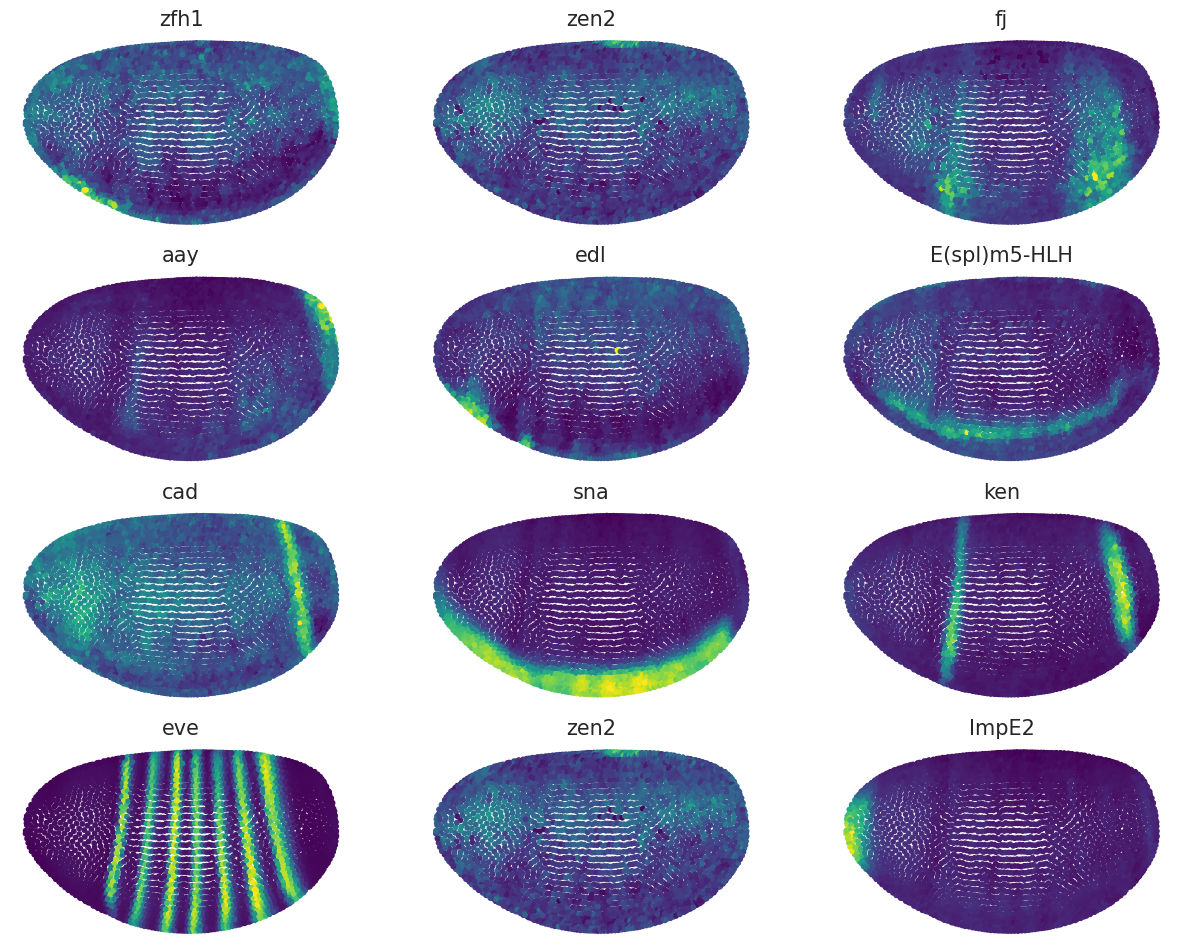

reconstructed


<Figure size 432x288 with 0 Axes>

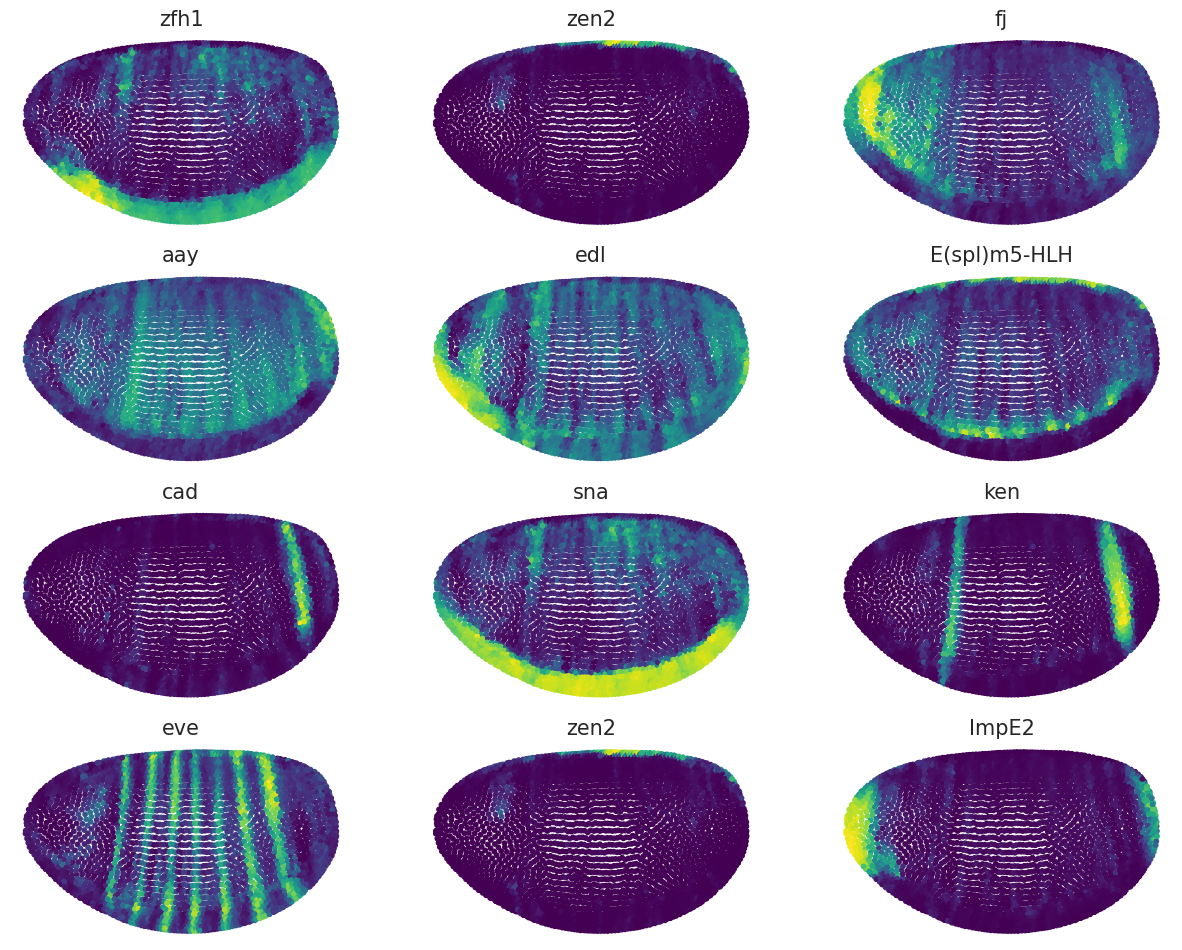

cleaned


<Figure size 432x288 with 0 Axes>

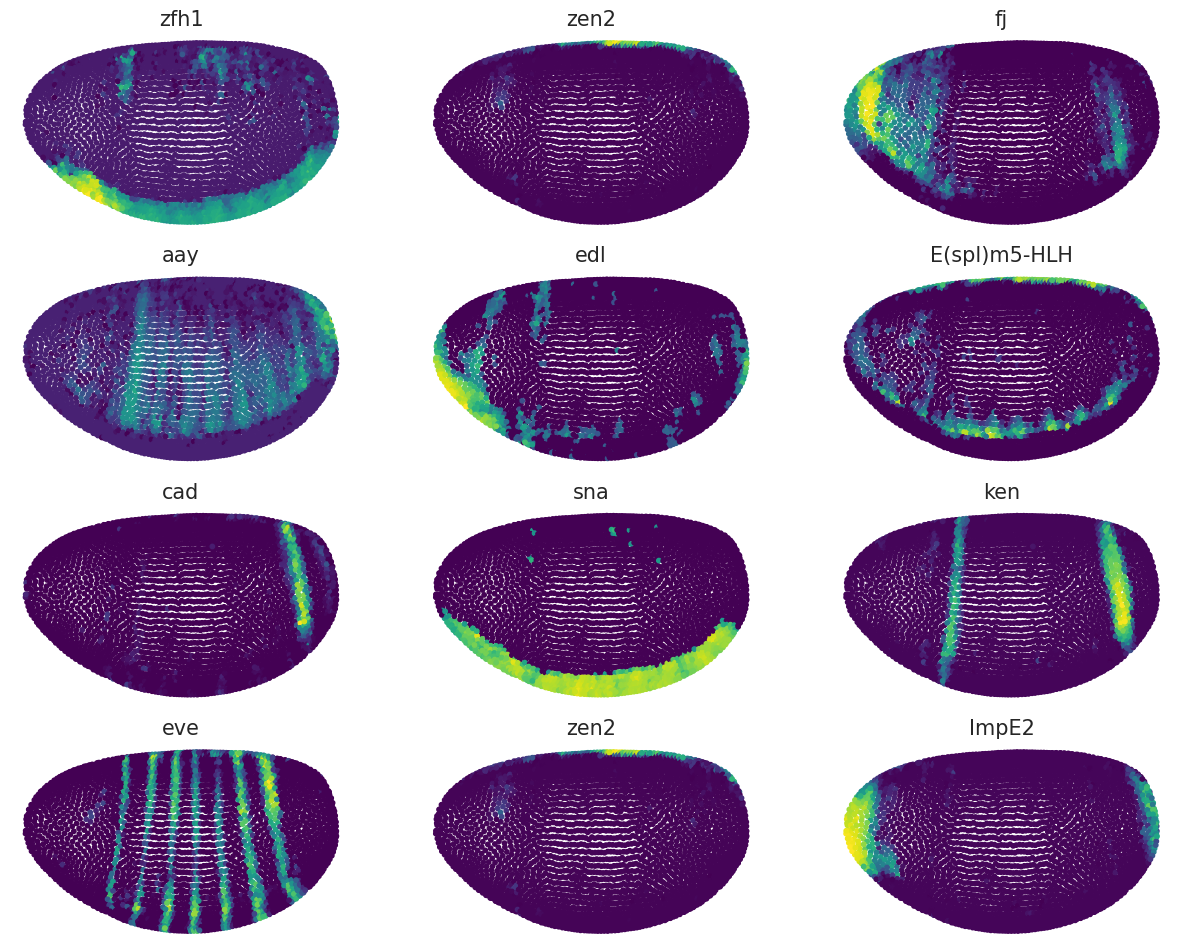

<Figure size 432x288 with 0 Axes>

In [68]:
investigation_genes = ["zfh1", "zen2", "fj", "aay",
                       "edl", "E(spl)m5-HLH", "cad", # reconstruction difficulties
                       'sna', 'ken', 'eve','zen2','ImpE2' # original pl_genes
                        ]
# test
plt.viridis()
print("truth")
novosparc.pl.embedding(atlas, investigation_genes)
print("reconstructed")
novosparc.pl.embedding(dataset_reconst, investigation_genes)
print("cleaned")
novosparc.pl.embedding(dataset_reconst_postcleaned, investigation_genes)

# Merging matrix and scale together

In [69]:
exprssn_mtrx_all = np.concatenate((exprmtrx_truth, exprmtrx_simplerecon, exprmtrx_recon_defaultGMM), axis=1)
print(exprmtrx_truth.shape)
print(exprmtrx_simplerecon.shape)
print(exprmtrx_recon_defaultGMM.shape)
print(exprssn_mtrx_all.shape)

(3039, 84)
(3039, 84)
(3039, 84)
(3039, 252)


In [70]:
exprssn_mtrx_all_scaled = scale(exprssn_mtrx_all)
expmtrx_truth_scaled = exprssn_mtrx_all_scaled[:,0:84]
exprmtrx_simplerecon_scaled = exprssn_mtrx_all_scaled[:,84:168]
exprmtrx_recon_defaultGMM_scaled = exprssn_mtrx_all_scaled[:,168:252]

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


# Comparing results
ToDo: also make this a function you can loop though just plotting the results in the end

## Correlation Measurement Functions

In [71]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

def mean_pearson(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = pearsonr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def mean_spearman(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = spearmanr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def box_swarm_label(plot_df, score_name, single_dfs=None):
    ## plot_df must contain columns "gene", "r score (pearson)", and "method" (being the  reconstruction/cleaning)

    figure(figsize=(11, 12), dpi=80)

    sns.boxplot(x="method", y=score_name, data=plot_df, whis=np.inf)
    sns.swarmplot(x="method", y=score_name, data=plot_df,
                  palette=["crimson","indigo"])

    if single_dfs:
        for counter, single_df in enumerate(single_dfs):

            for x,y, label in zip([counter]*len(plot_df), single_df[score_name], single_df["gene"]):
                plt.text(x = x + 0.1, y = y,
                         s = label,
                         rotation= 45)
    plt.show()

def filter_matrix_for_genes(dataframe, gene_list):
    filtered_df = dataframe[dataframe.gene.isin(gene_list)]
    return filtered_df

def mean_ssim(actual, pred):
    ssim_per_gene = []
    for i in range(actual.shape[1]):
        ssim_score= ssim(actual[:,i],pred[:,i],
                         data_range= pred[:,i].max() -  pred[:,i].min())
        ssim_per_gene.append(ssim_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return ssim_per_gene, np.mean(ssim_per_gene)
# def invest_plot_for_correlations(truth_df, list_of_expression_mtrx, list_of_special_genes, list_of_score_cutoffs)
# ToDo
plt.viridis()

<Figure size 432x288 with 0 Axes>

## Boxplots

median pearson; recon: 0.7271640722684104, clean:0.7345959900626189


<Figure size 432x288 with 0 Axes>

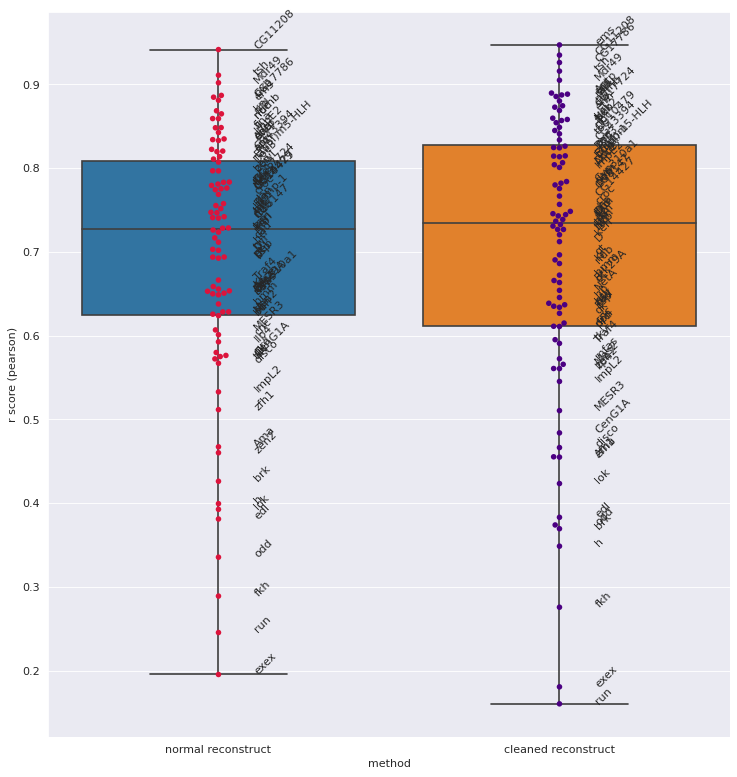

median spearman; recon: 0.559978483212084, clean:0.5413801036699281


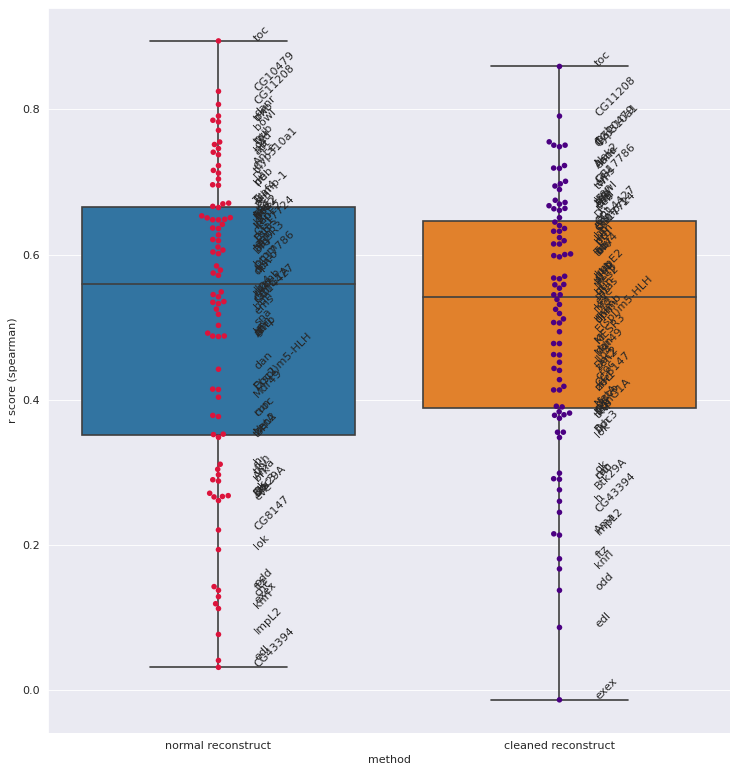

median cosine similarity; recon: 0.7271641492843628, clean:0.7346047163009644


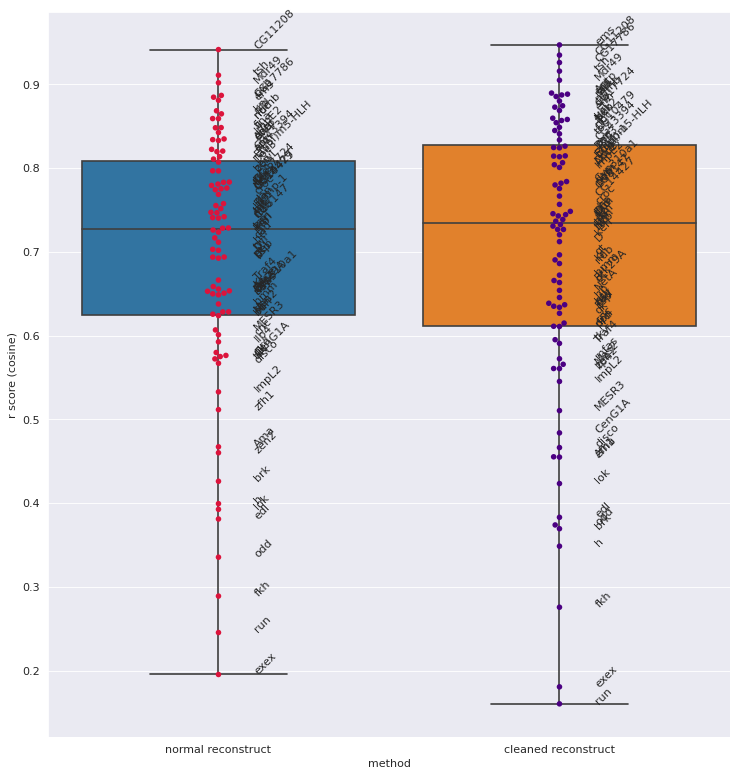

SSM none: 1.0
SSM reconstruction: 0.5218444953259184
SSM cleaning: 0.5492154861378161
median ssim gene-wise; recon: 0.24866614357058642, clean:0.2848138785379335


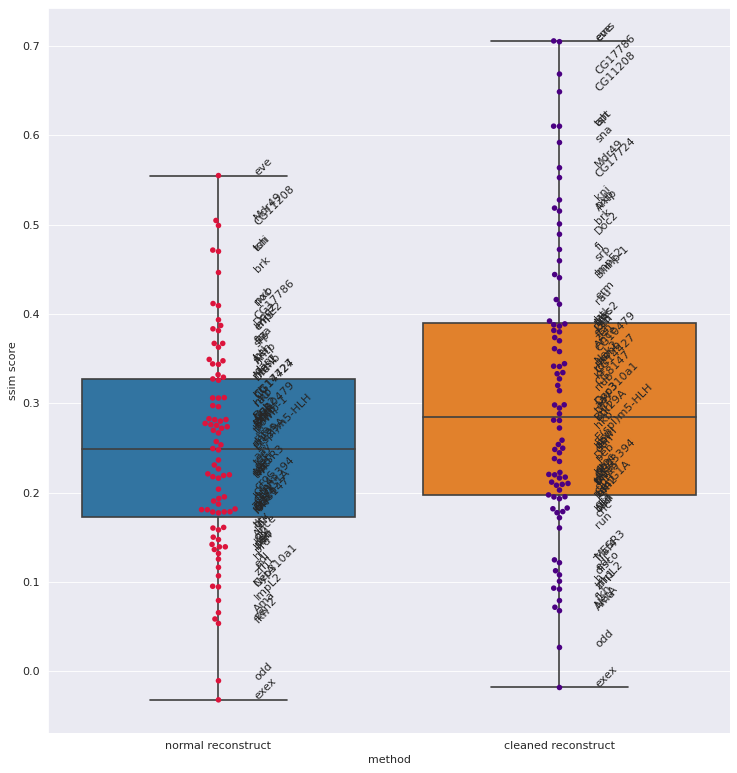

In [72]:
plt.viridis()
# pearson
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_pearson(expmtrx_truth_scaled, exprmtrx_simplerecon_scaled)
pearson_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes, r_values_recon, method_recon)),
                                            columns=["gene", "r score (pearson)", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_pearson(expmtrx_truth_scaled, exprmtrx_recon_defaultGMM_scaled)
pearson_corre_cleaned = pd.DataFrame(list(zip(atlas_genes, r_values_clean, method_clean)),
                                     columns=["gene", "r score (pearson)", "method"])

print(f"median pearson; recon: {np.median(r_values_recon)}, clean:{np.median(r_values_clean)}")
pearson_corre_plt = pd.concat([pearson_corre_reconstruction, pearson_corre_cleaned])
box_swarm_label(pearson_corre_plt, "r score (pearson)",
                [pearson_corre_reconstruction, pearson_corre_cleaned])

# spearman
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_spearman(expmtrx_truth_scaled, exprmtrx_simplerecon_scaled)
spearman_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (spearman)","method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_spearman(expmtrx_truth_scaled, exprmtrx_recon_defaultGMM_scaled)
spearman_corre_cleaned = pd.DataFrame(list(zip(atlas_genes,r_values_clean, method_clean)),
                                    columns=["gene","r score (spearman)","method"])

print(f"median spearman; recon: {np.median(r_values_recon)}, clean:{np.median(r_values_clean)}")
spearman_corre_plt = pd.concat([spearman_corre_reconstruction,spearman_corre_cleaned])
box_swarm_label(spearman_corre_plt,
                "r score (spearman)",
                [spearman_corre_reconstruction,spearman_corre_cleaned])



# cosine
method_recon = ["normal reconstruct"] * len(atlas_genes)
cosin_sim_values_recon = sklearn.metrics.pairwise.cosine_similarity(expmtrx_truth_scaled.T, exprmtrx_simplerecon_scaled.T)
cosin_sim_values_recon_diag = np.diag(cosin_sim_values_recon)
cosin_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes, cosin_sim_values_recon_diag, method_recon)),
                                          columns=["gene", "r score (cosine)", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
cosin_sim_values_clean = sklearn.metrics.pairwise.cosine_similarity(expmtrx_truth_scaled.T, exprmtrx_recon_defaultGMM_scaled.T)
cosin_sim_values_clean_diag = np.diag(cosin_sim_values_clean)
cosin_corre_cleaned = pd.DataFrame(list(zip(atlas_genes, cosin_sim_values_clean_diag, method_clean)),
                                   columns=["gene", "r score (cosine)", "method"])

print(f"median cosine similarity; recon: {np.median(cosin_sim_values_recon_diag)}, "
      f"clean:{np.median(cosin_sim_values_clean_diag)}")
cosine_corre_plt = pd.concat([cosin_corre_reconstruction, cosin_corre_cleaned])
box_swarm_label(cosine_corre_plt,
                "r score (cosine)",
                [cosin_corre_reconstruction, cosin_corre_cleaned])

# ssim - general

img = expmtrx_truth_scaled
img_noise = exprmtrx_simplerecon_scaled
img_const = exprmtrx_recon_defaultGMM_scaled

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:",ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print("SSM reconstruction:", ssim_noise)

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const, data_range=img_const.max() - img_const.min())

print("SSM cleaning:", ssim_const)
# ssim - per gene

method_recon = ["normal reconstruct"] * len(atlas_genes)
ssim_values_recon, mean_ssim_recon = mean_ssim(expmtrx_truth_scaled, exprmtrx_simplerecon_scaled)

ssim_reconstruction = pd.DataFrame(list(zip(atlas_genes, ssim_values_recon, method_recon)),
                                          columns=["gene", "ssim score", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
ssim_values_clean, mean_ssim_clean = mean_ssim(expmtrx_truth_scaled, exprmtrx_recon_defaultGMM_scaled)
ssim_cleaned = pd.DataFrame(list(zip(atlas_genes, ssim_values_clean, method_clean)),
                                   columns=["gene", "ssim score", "method"])

print(f"median ssim gene-wise; recon: {np.median(ssim_values_recon)}, clean:{np.median(ssim_values_clean)}")
ssim_plt = pd.concat([ssim_reconstruction, ssim_cleaned])
box_swarm_label(ssim_plt,
                "ssim score",
                [ssim_reconstruction, ssim_cleaned])

## Boxplots - without scaling

In [ ]:
# pearson
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_pearson(exprmtrx_truth, exprmtrx_simplerecon)
pearson_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes, r_values_recon, method_recon)),
                                            columns=["gene", "r score (pearson)", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_pearson(exprmtrx_truth, exprmtrx_recon_defaultGMM)
pearson_corre_cleaned = pd.DataFrame(list(zip(atlas_genes, r_values_clean, method_clean)),
                                     columns=["gene", "r score (pearson)", "method"])

print(f"median pearson; recon: {np.median(r_values_recon)}, clean:{np.median(r_values_clean)}")
pearson_corre_plt = pd.concat([pearson_corre_reconstruction, pearson_corre_cleaned])
box_swarm_label(pearson_corre_plt, "r score (pearson)",
                [pearson_corre_reconstruction, pearson_corre_cleaned])

# spearman
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_spearman(exprmtrx_truth, exprmtrx_simplerecon)
spearman_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (spearman)","method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_spearman(exprmtrx_truth, exprmtrx_recon_defaultGMM)
spearman_corre_cleaned = pd.DataFrame(list(zip(atlas_genes,r_values_clean, method_clean)),
                                    columns=["gene","r score (spearman)","method"])

print(f"median spearman; recon: {np.median(r_values_recon)}, clean:{np.median(r_values_clean)}")
spearman_corre_plt = pd.concat([spearman_corre_reconstruction,spearman_corre_cleaned])
box_swarm_label(spearman_corre_plt,
                "r score (spearman)",
                [spearman_corre_reconstruction,spearman_corre_cleaned])

# cosine
method_recon = ["normal reconstruct"] * len(atlas_genes)
cosin_sim_values_recon = sklearn.metrics.pairwise.cosine_similarity(exprmtrx_truth.T, exprmtrx_simplerecon.T)
cosin_sim_values_recon_diag = np.diag(cosin_sim_values_recon)
cosin_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes, cosin_sim_values_recon_diag, method_recon)),
                                          columns=["gene", "r score (cosine)", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
cosin_sim_values_clean = sklearn.metrics.pairwise.cosine_similarity(exprmtrx_truth.T, exprmtrx_recon_defaultGMM.T)
cosin_sim_values_clean_diag = np.diag(cosin_sim_values_clean)
cosin_corre_cleaned = pd.DataFrame(list(zip(atlas_genes, cosin_sim_values_clean_diag, method_clean)),
                                   columns=["gene", "r score (cosine)", "method"])

print(f"median cosine similarity; recon: {np.median(cosin_sim_values_recon_diag)}, "
      f"clean:{np.median(cosin_sim_values_clean_diag)}")
cosine_corre_plt = pd.concat([cosin_corre_reconstruction, cosin_corre_cleaned])
box_swarm_label(cosine_corre_plt,
                "r score (cosine)",
                [cosin_corre_reconstruction, cosin_corre_cleaned])

# ssim - general

img = exprmtrx_truth
img_noise = exprmtrx_simplerecon
img_const = exprmtrx_recon_defaultGMM

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:",ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print("SSM reconstruction:", ssim_noise)

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const, data_range=img_const.max() - img_const.min())

print("SSM cleaning:", ssim_const)
# ssim - per gene

method_recon = ["normal reconstruct"] * len(atlas_genes)
ssim_values_recon, mean_ssim_recon = mean_ssim(exprmtrx_truth, exprmtrx_simplerecon)

ssim_reconstruction = pd.DataFrame(list(zip(atlas_genes, ssim_values_recon, method_recon)),
                                          columns=["gene", "ssim score", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
ssim_values_clean, mean_ssim_clean = mean_ssim(exprmtrx_truth, exprmtrx_recon_defaultGMM)
ssim_cleaned = pd.DataFrame(list(zip(atlas_genes, ssim_values_clean, method_clean)),
                                   columns=["gene", "ssim score", "method"])

print(f"median ssim gene-wise; recon: {np.median(ssim_values_recon)}, clean:{np.median(ssim_values_clean)}")
ssim_plt = pd.concat([ssim_reconstruction, ssim_cleaned])
box_swarm_label(ssim_plt,
                "ssim score",
                [ssim_reconstruction, ssim_cleaned])

# Debug scoring
on the example of spearman

In [17]:
def mean_spearman(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = spearmanr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)


## comparison of truth matrix with it self - scaled and unscaled

median spearman; truth, unscaled: 1.0


/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


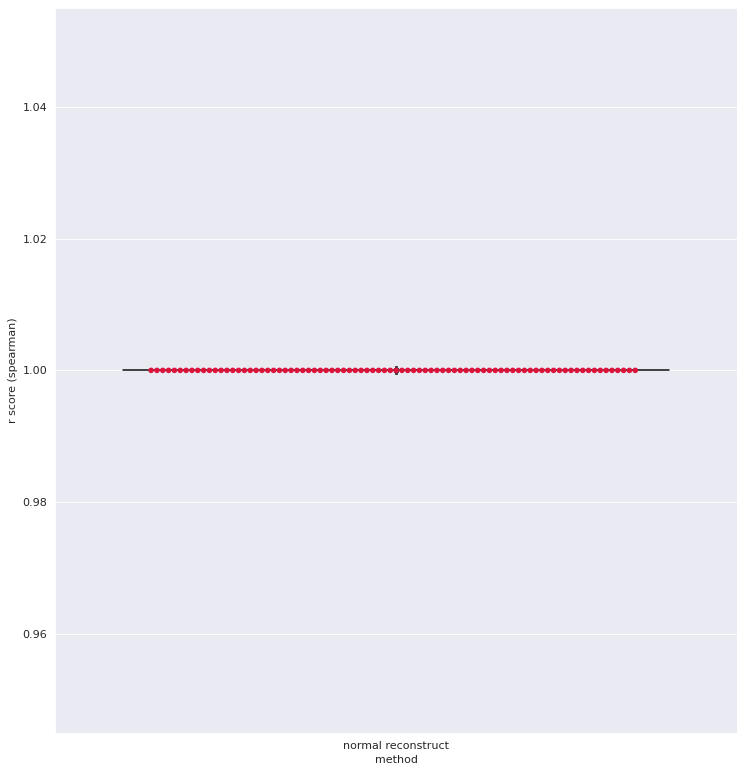

median spearman; truth, scaled: 1.0


/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


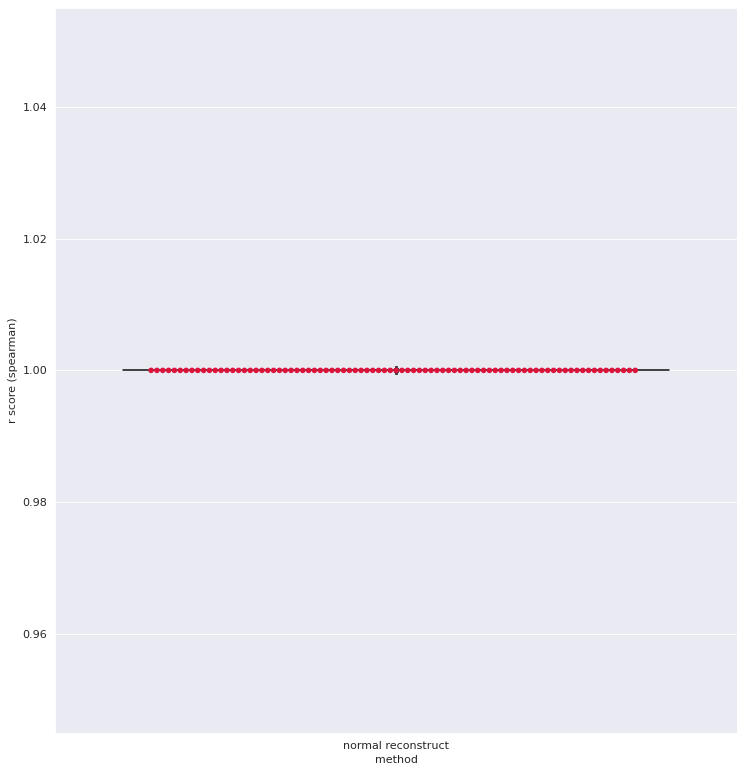

In [30]:
# unscaled
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_spearman(exprmtrx_truth, exprmtrx_truth)
spearman_corre_truth = pd.DataFrame(list(zip(atlas_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (spearman)","method"])

print(f"median spearman; truth, unscaled: {np.median(r_values_recon)}")
spearman_corre_plt = spearman_corre_truth
box_swarm_label(spearman_corre_plt,
                "r score (spearman)")
# scaled
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_spearman(expmtrx_truth_scaled, expmtrx_truth_scaled)
spearman_corre_truth = pd.DataFrame(list(zip(atlas_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (spearman)","method"])

print(f"median spearman; truth, scaled: {np.median(r_values_recon)}")
spearman_corre_plt = spearman_corre_truth
box_swarm_label(spearman_corre_plt,
                "r score (spearman)")

## Test genes

In [31]:
test_genes = ["zen2", "E(spl)m5-HLH",'sna', 'ken', 'eve']

## Subset expression matrices

In [58]:
# truth
subset_cols = []
picked_genes = []
for i, gene in enumerate(test_genes):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(atlas[:, gene].X).reshape(-1, 1))
        picked_genes.append(gene)
exprmtrx_truth_test = np.concatenate(subset_cols, axis=1)
exprmtrx_truth_test_genes = picked_genes

# reconstruction
subset_cols = []
picked_genes = []
for i, gene in enumerate(test_genes):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1, 1))
        picked_genes.append(gene)
exprmtrx_simplerecon_test = np.concatenate(subset_cols, axis=1)
exprmtrx_simplerecon_test_genes = picked_genes

# cleaning
subset_cols = []
picked_genes = []
for i, gene in enumerate(test_genes):
    if gene in dataset_reconst_postcleaned.var_names:
        subset_cols.append(np.asarray(dataset_reconst_postcleaned[:, gene].X).reshape(-1, 1))
        picked_genes.append(gene)
exprmtrx_recon_defaultGMM_test = np.concatenate(subset_cols, axis=1)
exprmtrx_recon_defaultGMM_test_genes = picked_genes

## reference plot

truth


<Figure size 432x288 with 0 Axes>

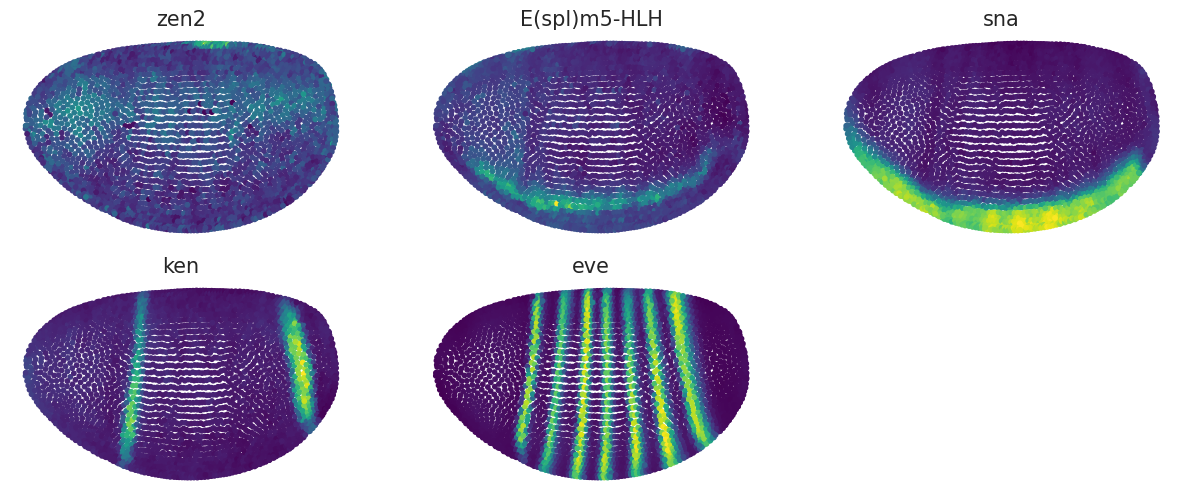

reconstructed


<Figure size 432x288 with 0 Axes>

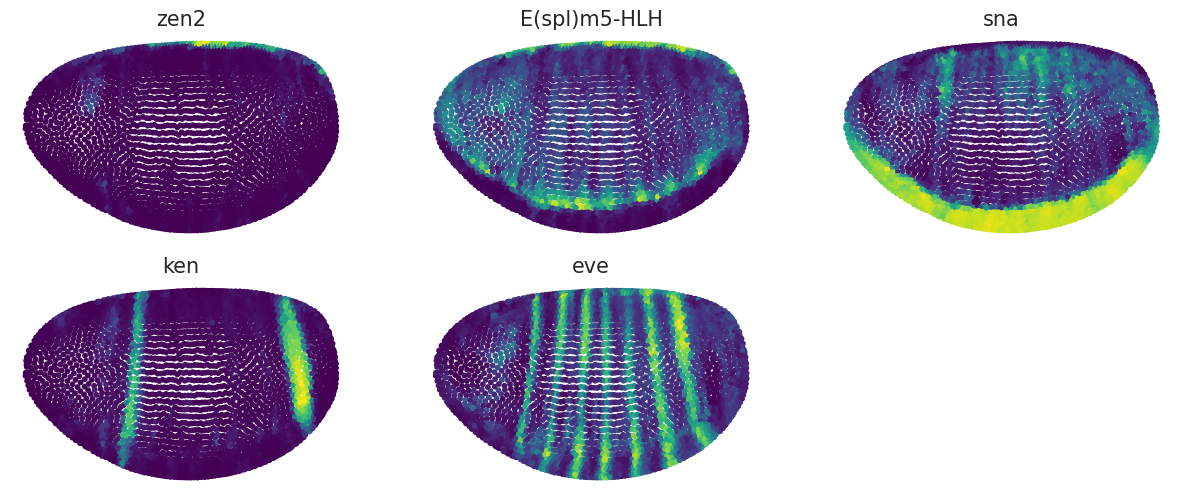

cleaned


<Figure size 432x288 with 0 Axes>

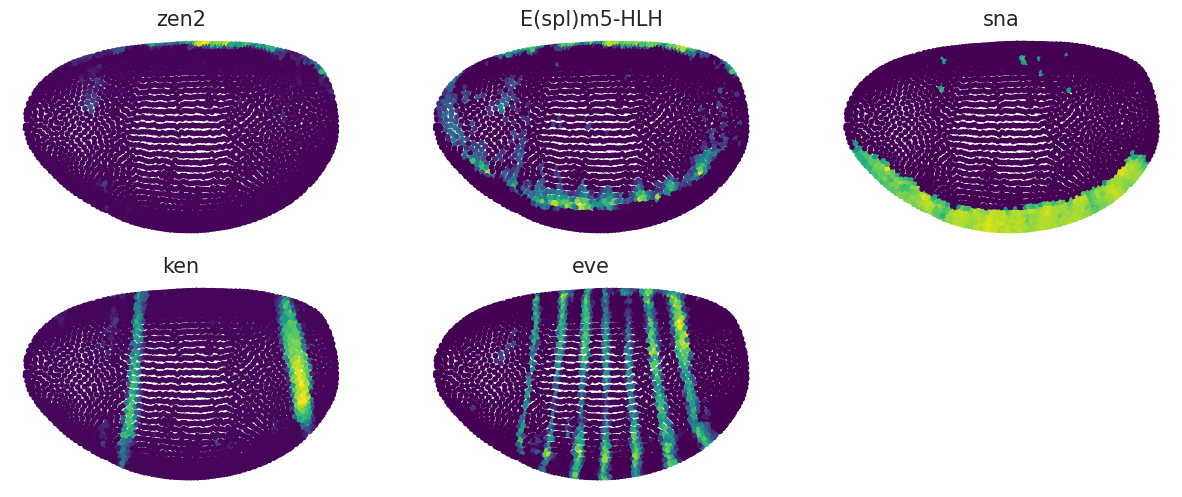

<Figure size 432x288 with 0 Axes>

In [33]:
plt.viridis()
print("truth")
novosparc.pl.embedding(atlas, test_genes)
print("reconstructed")
novosparc.pl.embedding(dataset_reconst, test_genes)
print("cleaned")
novosparc.pl.embedding(dataset_reconst_postcleaned, test_genes)

## unscaled spearman comparison

spearman value for sna: 0.517709688057572
spearman value boxplot for sna: 72    0.456363
Name: r score (spearman), dtype: float64


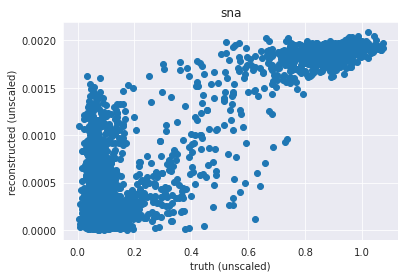

In [34]:
single_gene_truth = exprmtrx_truth_test[:,2]
single_gene_reconstructed = exprmtrx_simplerecon_test[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth, single_gene_reconstructed)
plt.title(gene)
plt.xlabel("truth (unscaled)")
plt.ylabel("reconstructed (unscaled)")

r_score,p_value = spearmanr(single_gene_truth, single_gene_reconstructed)
print(f"spearman value for {gene}:",r_score)

# value in boxplot above
r_score_analysis = spearman_corre_reconstruction[spearman_corre_reconstruction["gene"] == gene]
print(f"spearman value boxplot for {gene}:", r_score_analysis["r score (spearman)"])

## scaled spearman comparison - Merge&Split technique

### subset expression matrices - zscore

In [35]:
exprssn_mtrx_all_test = np.concatenate((exprmtrx_truth_test, exprmtrx_simplerecon_test, exprmtrx_recon_defaultGMM_test), axis=1)
print(exprmtrx_truth_test.shape)
print(exprmtrx_simplerecon_test.shape)
print(exprmtrx_recon_defaultGMM_test.shape)
print(exprssn_mtrx_all_test.shape)

(3039, 5)
(3039, 5)
(3039, 5)
(3039, 15)


In [36]:
exprssn_mtrx_all_scaled_test = zscore(exprssn_mtrx_all)
expmtrx_truth_scaled_test = exprssn_mtrx_all_scaled_test[:, 0:5]
exprmtrx_simplerecon_scaled_test = exprssn_mtrx_all_scaled_test[:, 5:10]
exprmtrx_recon_defaultGMM_scaled_test = exprssn_mtrx_all_scaled_test[:, 10:15]

spearman value for sna: 0.3268023271608964


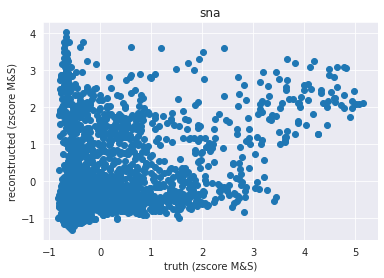

In [37]:
single_gene_truth_MergeSplitScale_zscore = expmtrx_truth_scaled_test[:,2]
single_gene_reconstructed_MergeSplitScale_zscore = exprmtrx_simplerecon_scaled_test[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth_MergeSplitScale_zscore, single_gene_reconstructed_MergeSplitScale_zscore)
plt.title(gene)
plt.xlabel("truth (zscore M&S)")
plt.ylabel("reconstructed (zscore M&S)")

r_score,p_value = spearmanr(single_gene_truth_MergeSplitScale_zscore, single_gene_reconstructed_MergeSplitScale_zscore)
print(f"spearman value for {gene}:", r_score)

# # value in boxplot above
# r_score_analysis = spearman_corre_reconstruction[spearman_corre_reconstruction["gene"] == gene]
# print(f"spearman value boxplot for {gene}:", r_score_analysis["r score (spearman)"])

### subset expression matrices - scale

In [38]:
exprssn_mtrx_all_scaled_test = scale(exprssn_mtrx_all)
expmtrx_truth_scaled_test = exprssn_mtrx_all_scaled_test[:, 0:5]
exprmtrx_simplerecon_scaled_test = exprssn_mtrx_all_scaled_test[:, 5:10]
exprmtrx_recon_defaultGMM_scaled_test = exprssn_mtrx_all_scaled_test[:, 10:15]

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


spearman value for sna: 0.3268023271608964
spearman value boxplot for sna: 72    0.456363
Name: r score (spearman), dtype: float64


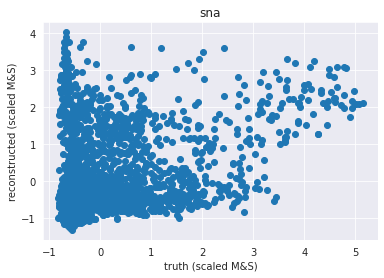

In [39]:
single_gene_truth_MergeSplitScale_scale = expmtrx_truth_scaled_test[:,2]
single_gene_reconstructed_MergeSplitScale_scale = exprmtrx_simplerecon_scaled_test[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth_MergeSplitScale_scale, single_gene_reconstructed_MergeSplitScale_scale)
plt.title(gene)
plt.xlabel("truth (scaled M&S)")
plt.ylabel("reconstructed (scaled M&S)")

r_score,p_value = spearmanr(single_gene_truth_MergeSplitScale_scale, single_gene_reconstructed_MergeSplitScale_scale)
print(f"spearman value for {gene}:", r_score)

# value in boxplot above
r_score_analysis = spearman_corre_reconstruction[spearman_corre_reconstruction["gene"] == gene]
print(f"spearman value boxplot for {gene}:", r_score_analysis["r score (spearman)"])

## scaled spearman comparison - scale seperately

### scale subset expression matrices - zscore

In [40]:
expmtrx_truth_scaled_test_zscore_seperate = zscore(exprmtrx_truth_test)
exprmtrx_simplerecon_scaled_test_zscore_seperate = zscore(exprmtrx_simplerecon_test)
exprmtrx_recon_defaultGMM_scaled_test_zscore_seperate = zscore(exprmtrx_recon_defaultGMM_test)

spearman value for sna: 0.5177092541473771
spearman value boxplot for sna: 72    0.456363
Name: r score (spearman), dtype: float64


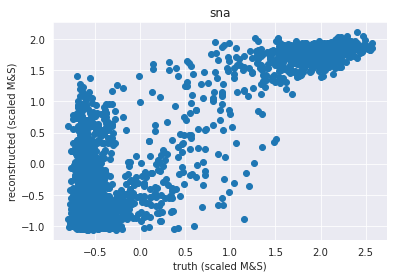

In [41]:
single_gene_truth_seperate_scale = expmtrx_truth_scaled_test_zscore_seperate[:,2]
single_gene_reconstructed_seperate_scale = exprmtrx_simplerecon_scaled_test_zscore_seperate[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth_seperate_scale, single_gene_reconstructed_seperate_scale)
plt.title(gene)
plt.xlabel("truth (scaled M&S)")
plt.ylabel("reconstructed (scaled M&S)")

r_score,p_value = spearmanr(single_gene_truth_seperate_scale, single_gene_reconstructed_seperate_scale)
print(f"spearman value for {gene}:", r_score)

# value in boxplot above
r_score_analysis = spearman_corre_reconstruction[spearman_corre_reconstruction["gene"] == gene]
print(f"spearman value boxplot for {gene}:", r_score_analysis["r score (spearman)"])

### scale whole test set - zscore

In [57]:
def mean_spearman(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = spearmanr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

# spearman
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_spearman(exprmtrx_truth, exprmtrx_simplerecon)
print(r_values_recon)
print(mean_corre_recon)
spearman_corre_reconstruction = pd.DataFrame(list(zip(test_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (spearman)","method"])

# print(spearman_corre_reconstruction)
# method_clean = ["cleaned reconstruct"] * len(atlas_genes)
# r_values_clean, mean_corre_clean = mean_spearman(exprmtrx_truth, exprmtrx_recon_defaultGMM)
# spearman_corre_cleaned = pd.DataFrame(list(zip(test_genes,r_values_clean, method_clean)),
#                                     columns=["gene","r score (spearman)","method"])
# print(mean_corre_clean)
# print(spearman_corre_cleaned)
# print(f"median spearman; recon: {np.median(r_values_recon)}, clean:{np.median(r_values_clean)}")
# spearman_corre_plt = pd.concat([spearman_corre_reconstruction,spearman_corre_cleaned])
# box_swarm_label(spearman_corre_plt,
#                 "r score (spearman)",
#                 [spearman_corre_reconstruction,spearman_corre_cleaned])

[0.3520785564866938, 0.8942343388819808, 0.4146178342392404, 0.6961076073224174, 0.7711436700272803, 0.6698173821794468, 0.6034963333929718, 0.4877205470290331, 0.7908396347482571, 0.7460287936138169, 0.5352334911331625, 0.0768029907098411, 0.1287982214945817, 0.584332228758603, 0.7122121795819296, 0.3111786597675958, 0.48781233062386425, 0.2712251720713706, 0.7827373058674822, 0.6415878507075543, 0.41418404936543823, 0.03148324710678377, 0.6477661257274109, 0.5485720911735779, 0.6504872220920949, 0.7409600060574061, 0.44206757311764194, 0.35262528505029955, 0.34823634278259014, 0.5418285422681643, 0.6953781287302521, 0.14261779767601648, 0.26617794789615695, 0.13754888428548084, 0.29666258285216296, 0.19358860037203135, 0.7849601264501505, 0.11238590529811521, 0.37843188444226683, 0.2611829121817076, 0.8067947014868615, 0.6206768579586636, 0.6508535545011572, 0.704087596412526, 0.6012045048948501, 0.3768214621335585, 0.48703896320939943, 0.6270583329540388, 0.26791757618778556, 0.5248

In [43]:
expmtrx_truth_scaled_test_zscore_seperate

array([[-0.58954924,  0.9899155 , -0.46014205,  0.04873014, -0.81502235],
       [ 0.29640096,  0.32888308, -0.11531577,  0.4332446 , -0.8035003 ],
       [ 1.0988327 ,  0.67365956, -0.31102833,  0.13556357, -0.8192266 ],
       ...,
       [-1.555915  ,  2.509776  ,  1.5396878 , -0.24059491, -0.7951435 ],
       [-0.3502446 ,  0.16961512,  2.004466  , -0.48313826, -0.10790248],
       [ 0.35966712, -0.6962124 , -0.7821967 , -0.5362687 , -0.6179424 ]],
      dtype=float32)

### scale subset expression matrices - scale

In [ ]:
expmtrx_truth_scaled_test_scale_separate = scale(exprmtrx_truth_test)
exprmtrx_simplerecon_scaled_test_scale_separate = scale(exprmtrx_simplerecon_test)
exprmtrx_recon_defaultGMM_scaled_test_scale_separate = scale(exprmtrx_recon_defaultGMM_test)

In [ ]:
single_gene_truth_separate_scale = expmtrx_truth_scaled_test_scale_separate[:,2]
single_gene_reconstructed_separate_scale = exprmtrx_simplerecon_scaled_test_scale_separate[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth_separate_scale, single_gene_reconstructed_separate_scale)
plt.title(gene)
plt.xlabel("truth (scaled M&S)")
plt.ylabel("reconstructed (scaled M&S)")

r_score,p_value = spearmanr(single_gene_truth_seperate_scale, single_gene_reconstructed_seperate_scale)
print(f"spearman value for {gene}:", r_score)

# value in boxplot above
r_score_analysis = spearman_corre_reconstruction[spearman_corre_reconstruction["gene"] == gene]
print(f"spearman value boxplot for {gene}:", r_score_analysis["r score (spearman)"])

## unscaled ssm comparison

In [ ]:
single_gene_truth = exprmtrx_truth_test[:,2]
single_gene_reconstructed = exprmtrx_simplerecon_test[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth, single_gene_reconstructed)
plt.title(gene)
plt.xlabel("truth (unscaled)")
plt.ylabel("reconstructed (unscaled)")


In [ ]:
# ssim - general

img = single_gene_truth
img_noise = single_gene_reconstructed

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:",ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print(f"SSM value for {gene}:", ssim_noise)
ssim_analysis = ssim_reconstruction[ssim_reconstruction["gene"] == gene]
print(f"SSM value for {gene} in boxplot:", ssim_analysis["ssim score"])

## scaled ssm comparison - Merge&Split

### subset expression matrices - zscore

## scaled ssm comparison - separate

### zscore

In [ ]:
expmtrx_truth_scaled_test_zscore_separate = zscore(exprmtrx_truth_test)
exprmtrx_simplerecon_scaled_test_zscore_separate = zscore(exprmtrx_simplerecon_test)
exprmtrx_recon_defaultGMM_scaled_test_zscore_separate = zscore(exprmtrx_recon_defaultGMM_test)

In [ ]:
single_gene_truth_separate_zscore = expmtrx_truth_scaled_test_zscore_seperate[:,2]
single_gene_reconstructed_separate_zscore = exprmtrx_simplerecon_scaled_test_zscore_seperate[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth_separate_zscore, single_gene_reconstructed_separate_zscore)
plt.title(gene)
plt.xlabel("truth (scaled separate)")
plt.ylabel("reconstructed (scaled separate)")

In [ ]:
# ssim - general
img = single_gene_truth_separate_zscore
img_noise = single_gene_reconstructed_separate_zscore

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:",ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print(f"SSM value for {gene}:", ssim_noise)
ssim_analysis = ssim_reconstruction[ssim_reconstruction["gene"] == gene]
print(f"SSM value for {gene} in boxplot:", ssim_analysis["ssim score"])

### scale

In [ ]:
expmtrx_truth_scaled_test_scale_separate = scale(exprmtrx_truth_test)
exprmtrx_simplerecon_scaled_test_scale_separate = scale(exprmtrx_simplerecon_test)
exprmtrx_recon_defaultGMM_scaled_test_scale_separate = scale(exprmtrx_recon_defaultGMM_test)

In [ ]:
help(scale)

In [ ]:
single_gene_truth_separate_scale = expmtrx_truth_scaled_test_scale_separate[:, 2]
single_gene_reconstructed_separate_scale = exprmtrx_simplerecon_scaled_test_scale_separate[:, 2]
gene = test_genes[2]

plt.scatter(single_gene_truth_separate_scale, single_gene_reconstructed_separate_scale)
plt.title(gene)
plt.xlabel("truth (scaled separate)")
plt.ylabel("reconstructed (scaled separate)")

In [ ]:
# ssim - general
img = single_gene_truth_separate_scale
img_noise = single_gene_reconstructed_separate_scale

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:", ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print(f"SSM value for {gene}:", ssim_noise)
ssim_analysis = ssim_reconstruction[ssim_reconstruction["gene"] == gene]
print(f"SSM value for {gene} in boxplot:", ssim_analysis["ssim score"])

In [ ]:
single_gene_truth_separate_scale = expmtrx_truth_scaled_test_scale_separate[:, 2]
single_gene_reconstructed_separate_scale = exprmtrx_simplerecon_scaled_test_scale_separate[:, 2]
gene = test_genes[2]

plt.scatter(single_gene_truth_separate_scale, single_gene_reconstructed_separate_scale)
plt.title(gene)
plt.xlabel("truth (scaled separate)")
plt.ylabel("reconstructed (scaled separate)")

In [ ]:
# ssim - general
img = single_gene_truth_separate_scale
img_noise = single_gene_reconstructed_separate_scale

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:", ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print(f"SSM value for {gene}:", ssim_noise)
ssim_analysis = ssim_reconstruction[ssim_reconstruction["gene"] == gene]
print(f"SSM value for {gene} in boxplot:", ssim_analysis["ssim score"])

### subset expression matrices - zscore

## scaled ssm comparison - separate

### zscore

In [ ]:
expmtrx_truth_scaled_test_zscore_separate = zscore(exprmtrx_truth_test)
exprmtrx_simplerecon_scaled_test_zscore_separate = zscore(exprmtrx_simplerecon_test)
exprmtrx_recon_defaultGMM_scaled_test_zscore_separate = zscore(exprmtrx_recon_defaultGMM_test)

In [ ]:
single_gene_truth_separate_zscore = expmtrx_truth_scaled_test_zscore_seperate[:,2]
single_gene_reconstructed_separate_zscore = exprmtrx_simplerecon_scaled_test_zscore_seperate[:,2]
gene = test_genes[2]

plt.scatter(single_gene_truth_separate_zscore, single_gene_reconstructed_separate_zscore)
plt.title(gene)
plt.xlabel("truth (scaled separate)")
plt.ylabel("reconstructed (scaled separate)")

In [ ]:
# ssim - general
img = single_gene_truth_separate_zscore
img_noise = single_gene_reconstructed_separate_zscore

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:",ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print(f"SSM value for {gene}:", ssim_noise)
ssim_analysis = ssim_reconstruction[ssim_reconstruction["gene"] == gene]
print(f"SSM value for {gene} in boxplot:", ssim_analysis["ssim score"])

### scale

In [ ]:
expmtrx_truth_scaled_test_scale_separate = scale(exprmtrx_truth_test)
exprmtrx_simplerecon_scaled_test_scale_separate = scale(exprmtrx_simplerecon_test)
exprmtrx_recon_defaultGMM_scaled_test_scale_separate = scale(exprmtrx_recon_defaultGMM_test)

In [ ]:
single_gene_truth_separate_scale = expmtrx_truth_scaled_test_scale_separate[:, 2]
single_gene_reconstructed_separate_scale = exprmtrx_simplerecon_scaled_test_scale_separate[:, 2]
gene = test_genes[2]

plt.scatter(single_gene_truth_separate_scale, single_gene_reconstructed_separate_scale)
plt.title(gene)
plt.xlabel("truth (scaled separate)")
plt.ylabel("reconstructed (scaled separate)")

In [ ]:
# ssim - general
img = single_gene_truth_separate_scale
img_noise = single_gene_reconstructed_separate_scale

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:", ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print(f"SSM value for {gene}:", ssim_noise)
ssim_analysis = ssim_reconstruction[ssim_reconstruction["gene"] == gene]
print(f"SSM value for {gene} in boxplot:", ssim_analysis["ssim score"])